# STL-10 CNN Implementation (Refactored)

This notebook implements a custom CNN for the STL-10 dataset using standard PyTorch loops, replacing the Hugging Face Trainer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import itertools

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Preparation

In [ ]:
# Define Transforms
train_transform = transforms.Compose([
    # Input is 96x96. We RandomCrop to 64x64
    transforms.RandomCrop(64),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    # CenterCrop to 64x64 for testing
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load Datasets
# Note: We load the training data twice to apply different transforms to train vs val subsets seamlessly
# or we can rely on Subset. However, Subset inherits the dataset's transform.
# A cleaner way is to create two dataset instances.

full_train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=None)
test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=test_transform)

# Split indices
targets = full_train_dataset.labels
train_idx, val_idx = train_test_split(
    np.arange(len(full_train_dataset)),
    test_size=0.2,
    shuffle=True,
    stratify=targets,
    random_state=42
)

# Create Subsets
# To properly handle transforms, we'll create two base datasets with correct transforms
train_base = datasets.STL10(root='./data', split='train', download=True, transform=train_transform)
val_base = datasets.STL10(root='./data', split='train', download=True, transform=test_transform)

# Full training datasets for final training
train_ds_aug = train_base
train_ds_clean = val_base

train_set = Subset(train_base, train_idx)
val_set = Subset(val_base, val_idx)

# Create DataLoader for test evaluation
batch_size = 128 # Increased batch size for more stable gradients
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train Size: {len(train_set)} | Val Size: {len(val_set)} | Test Size: {len(test_dataset)}")

Train Size: 4000 | Val Size: 1000 | Test Size: 8000


In [3]:
# Visualization function
labels_map = {
    0 : "Airplane", 1 : "Bird", 2 : "Car", 3 : "Cat", 4 : "Deer",
    5 : "Dog", 6 : "Horse", 7 : "Monkey", 8 : "Ship", 9 : "Truck"
}

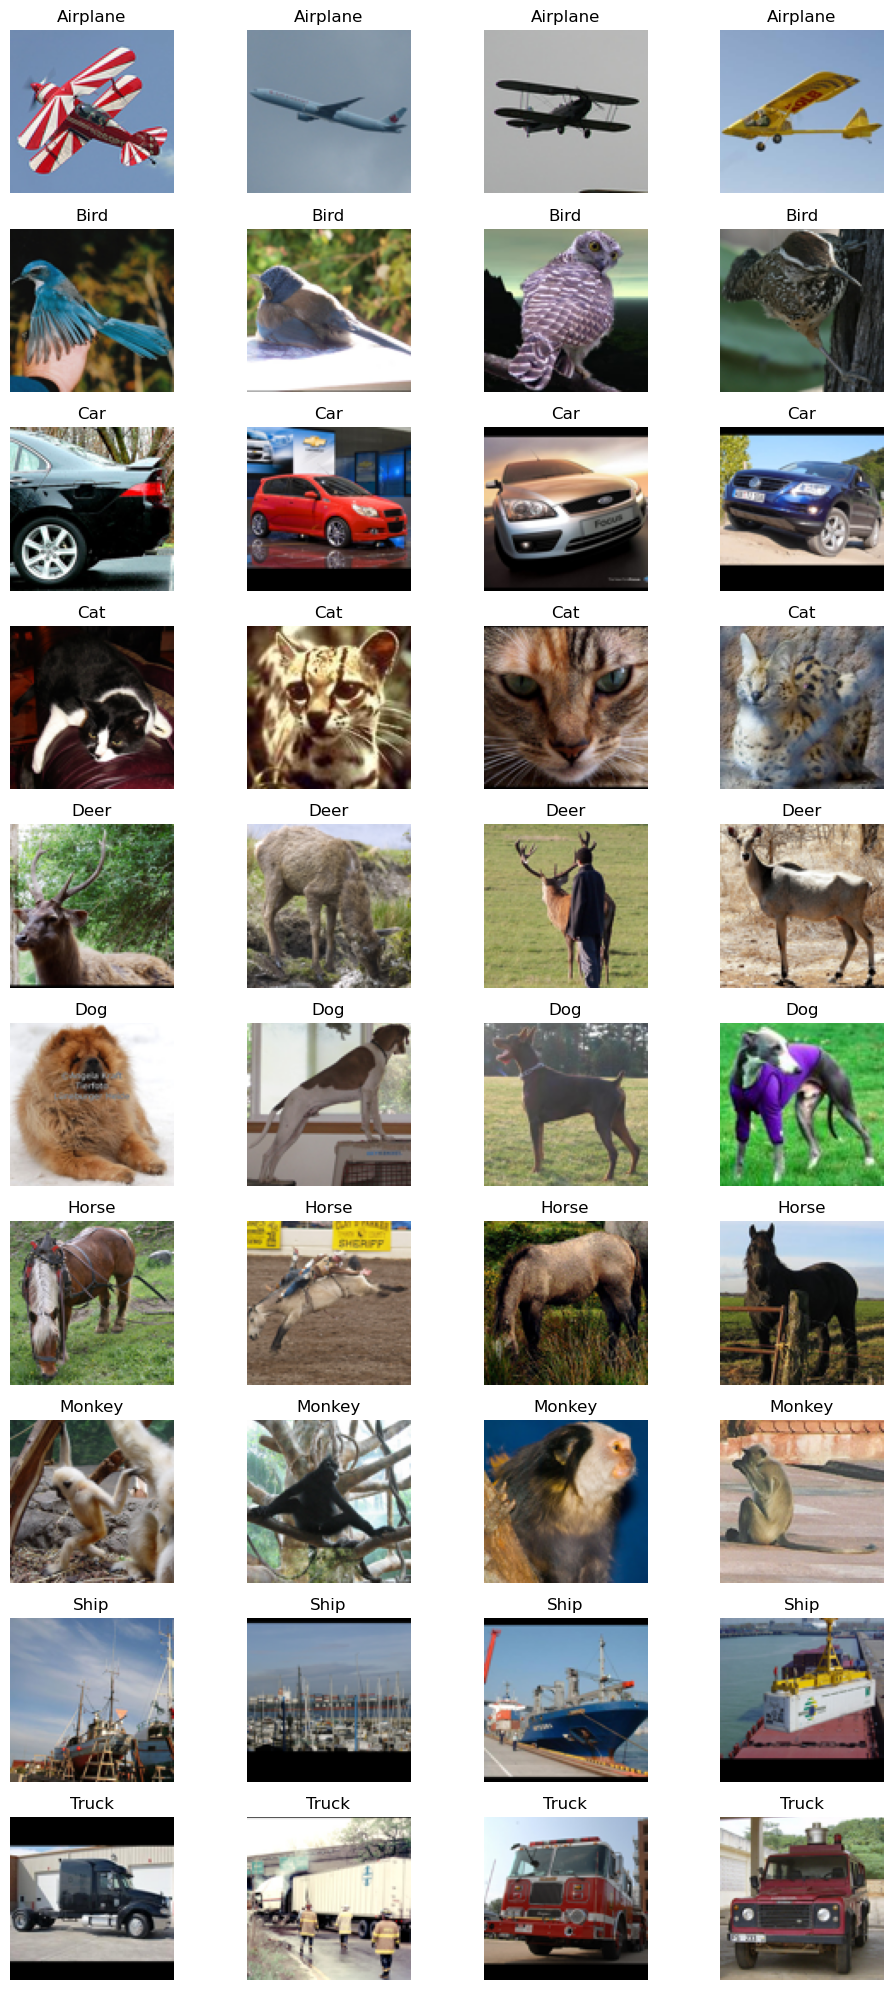

In [4]:
# plot 4 different examples from each class
# configure the plot
fig, axes = plt.subplots(nrows = 10, ncols = 4, figsize=(10,20))
# iterate over 10 classes
for i in range(10):
    # Filter data for this class
    class_i_examples = full_train_dataset.data[full_train_dataset.labels == i]

    # Pick 4 random indices
    idx = np.random.randint(0, class_i_examples.shape[0], 4)

    for j in range(4):
        img = class_i_examples[idx[j]]
        ax = axes[i, j]

        # Call the fixed function
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set_title(labels_map[i])

        # Remove axis ticks for cleanliness
        ax.axis("off")
plt.tight_layout()
plt.show()


## Model Definition

In [5]:
class CNN(nn.Module):
   def __init__(self, num_classes=10, base_width=8):
      super(CNN, self).__init__()

      c1 = base_width
      c2 = base_width * 2
      c3 = base_width * 4
      c4 = base_width * 8

      # Scalable Architecture: c1 -> c2 -> c3 -> c4
      # Block 1: spatial /2
      self.conv1 = nn.Conv2d(3, c1, kernel_size=3, padding=1)
      self.bn1 = nn.BatchNorm2d(c1)
      self.pool1 = nn.MaxPool2d(2, 2)

      # Block 2: spatial /2
      self.conv2 = nn.Conv2d(c1, c2, kernel_size=3, padding=1)
      self.bn2 = nn.BatchNorm2d(c2)
      self.pool2 = nn.MaxPool2d(2, 2)

      # Block 3: spatial /2
      self.conv3 = nn.Conv2d(c2, c3, kernel_size=3, padding=1)
      self.bn3 = nn.BatchNorm2d(c3)
      self.pool3 = nn.MaxPool2d(2, 2)

      # Block 4: spatial /2
      self.conv4 = nn.Conv2d(c3, c4, kernel_size=3, padding=1)
      self.bn4 = nn.BatchNorm2d(c4)
      self.pool4 = nn.MaxPool2d(2, 2)

      # Global Average Pooling: spatial -> 1x1
      self.gap = nn.AdaptiveAvgPool2d(1)
      
      # Classifier with 2 FC Layers + Classification Layer
      self.classifier = nn.Sequential(
          nn.Flatten(),
          # FC Layer 1
          nn.Linear(c4, 256),
          nn.ReLU(),
          nn.Dropout(0.5),
          # FC Layer 2
          nn.Linear(256, 128),
          nn.ReLU(),
          nn.Dropout(0.5),
          # Classification Layer
          nn.Linear(128, num_classes)
      )

   def forward(self, x):
      # Block 1
      x = self.pool1(F.relu(self.bn1(self.conv1(x))))
      # Block 2
      x = self.pool2(F.relu(self.bn2(self.conv2(x))))
      # Block 3
      x = self.pool3(F.relu(self.bn3(self.conv3(x))))
      # Block 4
      x = self.pool4(F.relu(self.bn4(self.conv4(x))))

      # Classifier
      x = self.gap(x)
      x = self.classifier(x)
      return x

# Instantiate Model
model = CNN(num_classes=10, base_width=8).to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

## Grid Search with Hold-Out Validation

In [ ]:
# Define Grid Search Space
base_widths = [8, 16]
batch_sizes = [64, 128]
weight_decays = [1e-3, 1e-4]
epochs_per_config = 30

optimizer_lrs = {
    "adam": [1e-3, 5e-4],
    "sgd": [1e-2, 1e-3]
}

param_grid = {
    "base_width": base_widths,
    "batch_size": batch_sizes,
    "weight_decay": weight_decays,
    "opt_lr": [(opt, lr) for opt, lrs in optimizer_lrs.items() for lr in lrs]
}

keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
print(f"Starting grid search with {len(combinations)} candidates...")

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

def evaluate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

results = []
best_acc = 0.0
best_params = None

for params in tqdm(combinations):
    base_width = params["base_width"]
    batch_size = params["batch_size"]
    wd = params["weight_decay"]
    opt_name, lr = params["opt_lr"]

    print(f"\nConfig: width={base_width}, opt={opt_name}, bs={batch_size}, lr={lr}, wd={wd}")

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

    model = CNN(num_classes=10, base_width=base_width).to(device)
    criterion = nn.CrossEntropyLoss()
    if opt_name == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

    best_val_acc = 0.0
    for epoch in tqdm(range(1, epochs_per_config + 1)):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        val_acc = evaluate_accuracy(model, val_loader)
        if val_acc > best_val_acc:
            best_val_acc = val_acc

        if epoch % 10 == 1 or epoch == epochs_per_config:
            print(f"  Epoch {epoch}/{epochs_per_config} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.2f}%")

    results.append({
        "base_width": base_width,
        "optimizer": opt_name,
        "batch_size": batch_size,
        "lr": lr,
        "weight_decay": wd,
        "best_val_acc": best_val_acc
    })

    print(f"  Best Val Acc: {best_val_acc:.2f}%")
    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_params = {
            "base_width": base_width,
            "optimizer": opt_name,
            "batch_size": batch_size,
            "lr": lr,
            "weight_decay": wd
        }

results = sorted(results, key=lambda x: x["best_val_acc"], reverse=True)
print("\nTop Configurations:")
for i, r in enumerate(results[:5], start=1):
    print(
        f"{i}. width={r['base_width']}, opt={r['optimizer']}, bs={r['batch_size']}, "
        f"lr={r['lr']}, wd={r['weight_decay']}, best_val_acc={r['best_val_acc']:.2f}%"
    )

if best_params is not None:
    print(
        f"\nBest Hyperparameters Found: width={best_params['base_width']}, opt={best_params['optimizer']}, "
        f"bs={best_params['batch_size']}, lr={best_params['lr']}, wd={best_params['weight_decay']} "
        f"(Acc: {best_acc:.2f}%)"
    )


Starting grid search with 32 candidates...


  0%|          | 0/32 [00:00<?, ?it/s]


Config: width=8, opt=adam, bs=64, lr=0.001, wd=0.001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.1669 | Val Acc: 25.50%
  Epoch 11/30 | Train Loss: 1.6421 | Val Acc: 42.50%
  Epoch 21/30 | Train Loss: 1.4930 | Val Acc: 46.20%
  Epoch 30/30 | Train Loss: 1.3794 | Val Acc: 46.90%
  Best Val Acc: 53.20%

Config: width=8, opt=adam, bs=64, lr=0.0005, wd=0.001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.2447 | Val Acc: 22.10%
  Epoch 11/30 | Train Loss: 1.6248 | Val Acc: 41.30%
  Epoch 21/30 | Train Loss: 1.4454 | Val Acc: 50.10%
  Epoch 30/30 | Train Loss: 1.3853 | Val Acc: 47.20%
  Best Val Acc: 53.10%

Config: width=8, opt=sgd, bs=64, lr=0.01, wd=0.001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.2601 | Val Acc: 22.50%
  Epoch 11/30 | Train Loss: 1.6901 | Val Acc: 36.30%
  Epoch 21/30 | Train Loss: 1.5226 | Val Acc: 48.90%
  Epoch 30/30 | Train Loss: 1.4252 | Val Acc: 50.40%
  Best Val Acc: 52.90%

Config: width=8, opt=sgd, bs=64, lr=0.001, wd=0.001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.3123 | Val Acc: 13.50%
  Epoch 11/30 | Train Loss: 1.9358 | Val Acc: 26.20%
  Epoch 21/30 | Train Loss: 1.7935 | Val Acc: 28.60%
  Epoch 30/30 | Train Loss: 1.7591 | Val Acc: 30.20%
  Best Val Acc: 30.50%

Config: width=8, opt=adam, bs=64, lr=0.001, wd=0.0001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.1288 | Val Acc: 23.10%
  Epoch 11/30 | Train Loss: 1.6029 | Val Acc: 36.90%
  Epoch 21/30 | Train Loss: 1.4142 | Val Acc: 51.40%
  Epoch 30/30 | Train Loss: 1.3495 | Val Acc: 54.40%
  Best Val Acc: 54.40%

Config: width=8, opt=adam, bs=64, lr=0.0005, wd=0.0001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.2439 | Val Acc: 23.10%
  Epoch 11/30 | Train Loss: 1.6461 | Val Acc: 41.90%
  Epoch 21/30 | Train Loss: 1.5163 | Val Acc: 49.50%
  Epoch 30/30 | Train Loss: 1.4267 | Val Acc: 53.20%
  Best Val Acc: 53.50%

Config: width=8, opt=sgd, bs=64, lr=0.01, wd=0.0001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.2570 | Val Acc: 23.10%
  Epoch 11/30 | Train Loss: 1.7053 | Val Acc: 34.30%
  Epoch 21/30 | Train Loss: 1.5656 | Val Acc: 40.40%
  Epoch 30/30 | Train Loss: 1.4389 | Val Acc: 50.50%
  Best Val Acc: 50.50%

Config: width=8, opt=sgd, bs=64, lr=0.001, wd=0.0001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.3069 | Val Acc: 16.10%
  Epoch 11/30 | Train Loss: 1.9993 | Val Acc: 22.70%
  Epoch 21/30 | Train Loss: 1.8441 | Val Acc: 27.80%
  Epoch 30/30 | Train Loss: 1.7603 | Val Acc: 31.70%
  Best Val Acc: 32.10%

Config: width=8, opt=adam, bs=128, lr=0.001, wd=0.001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.2077 | Val Acc: 15.10%
  Epoch 11/30 | Train Loss: 1.6469 | Val Acc: 42.00%
  Epoch 21/30 | Train Loss: 1.5142 | Val Acc: 46.90%
  Epoch 30/30 | Train Loss: 1.4395 | Val Acc: 46.80%
  Best Val Acc: 47.10%

Config: width=8, opt=adam, bs=128, lr=0.0005, wd=0.001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.2431 | Val Acc: 18.20%
  Epoch 11/30 | Train Loss: 1.7118 | Val Acc: 33.40%
  Epoch 21/30 | Train Loss: 1.5954 | Val Acc: 43.20%
  Epoch 30/30 | Train Loss: 1.5169 | Val Acc: 45.70%
  Best Val Acc: 46.70%

Config: width=8, opt=sgd, bs=128, lr=0.01, wd=0.001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.3067 | Val Acc: 14.40%
  Epoch 11/30 | Train Loss: 1.7543 | Val Acc: 31.10%
  Epoch 21/30 | Train Loss: 1.6473 | Val Acc: 29.30%
  Epoch 30/30 | Train Loss: 1.5509 | Val Acc: 44.30%
  Best Val Acc: 44.40%

Config: width=8, opt=sgd, bs=128, lr=0.001, wd=0.001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.3198 | Val Acc: 14.00%
  Epoch 11/30 | Train Loss: 2.2036 | Val Acc: 22.20%
  Epoch 21/30 | Train Loss: 1.9450 | Val Acc: 27.60%
  Epoch 30/30 | Train Loss: 1.8368 | Val Acc: 28.80%
  Best Val Acc: 29.90%

Config: width=8, opt=adam, bs=128, lr=0.001, wd=0.0001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.1789 | Val Acc: 23.70%
  Epoch 11/30 | Train Loss: 1.6403 | Val Acc: 36.00%
  Epoch 21/30 | Train Loss: 1.4676 | Val Acc: 48.00%
  Epoch 30/30 | Train Loss: 1.3899 | Val Acc: 51.30%
  Best Val Acc: 51.30%

Config: width=8, opt=adam, bs=128, lr=0.0005, wd=0.0001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.2759 | Val Acc: 21.00%
  Epoch 11/30 | Train Loss: 1.6900 | Val Acc: 35.60%
  Epoch 21/30 | Train Loss: 1.5241 | Val Acc: 47.20%
  Epoch 30/30 | Train Loss: 1.4377 | Val Acc: 45.40%
  Best Val Acc: 50.80%

Config: width=8, opt=sgd, bs=128, lr=0.01, wd=0.0001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.2956 | Val Acc: 18.80%
  Epoch 11/30 | Train Loss: 1.7310 | Val Acc: 33.10%
  Epoch 21/30 | Train Loss: 1.6023 | Val Acc: 39.80%
  Epoch 30/30 | Train Loss: 1.5105 | Val Acc: 45.50%
  Best Val Acc: 45.50%

Config: width=8, opt=sgd, bs=128, lr=0.001, wd=0.0001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.3051 | Val Acc: 15.60%
  Epoch 11/30 | Train Loss: 2.1906 | Val Acc: 21.80%
  Epoch 21/30 | Train Loss: 1.9770 | Val Acc: 27.40%
  Epoch 30/30 | Train Loss: 1.8467 | Val Acc: 27.50%
  Best Val Acc: 28.90%

Config: width=16, opt=adam, bs=64, lr=0.001, wd=0.001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.0787 | Val Acc: 27.40%
  Epoch 11/30 | Train Loss: 1.5475 | Val Acc: 45.60%
  Epoch 21/30 | Train Loss: 1.3455 | Val Acc: 50.40%
  Epoch 30/30 | Train Loss: 1.2589 | Val Acc: 49.90%
  Best Val Acc: 57.40%

Config: width=16, opt=adam, bs=64, lr=0.0005, wd=0.001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.1407 | Val Acc: 25.80%
  Epoch 11/30 | Train Loss: 1.4988 | Val Acc: 45.00%
  Epoch 21/30 | Train Loss: 1.3677 | Val Acc: 54.20%
  Epoch 30/30 | Train Loss: 1.2943 | Val Acc: 49.90%
  Best Val Acc: 58.00%

Config: width=16, opt=sgd, bs=64, lr=0.01, wd=0.001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.2350 | Val Acc: 24.30%
  Epoch 11/30 | Train Loss: 1.6570 | Val Acc: 39.40%
  Epoch 21/30 | Train Loss: 1.4641 | Val Acc: 46.40%
  Epoch 30/30 | Train Loss: 1.3518 | Val Acc: 48.30%
  Best Val Acc: 52.00%

Config: width=16, opt=sgd, bs=64, lr=0.001, wd=0.001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.3091 | Val Acc: 15.00%
  Epoch 11/30 | Train Loss: 1.8676 | Val Acc: 30.10%
  Epoch 21/30 | Train Loss: 1.7652 | Val Acc: 31.60%
  Epoch 30/30 | Train Loss: 1.6869 | Val Acc: 37.00%
  Best Val Acc: 37.50%

Config: width=16, opt=adam, bs=64, lr=0.001, wd=0.0001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.0938 | Val Acc: 23.30%
  Epoch 11/30 | Train Loss: 1.5326 | Val Acc: 50.00%
  Epoch 21/30 | Train Loss: 1.3602 | Val Acc: 43.30%
  Epoch 30/30 | Train Loss: 1.2844 | Val Acc: 54.90%
  Best Val Acc: 57.20%

Config: width=16, opt=adam, bs=64, lr=0.0005, wd=0.0001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.1949 | Val Acc: 22.10%
  Epoch 11/30 | Train Loss: 1.5274 | Val Acc: 39.00%
  Epoch 21/30 | Train Loss: 1.3624 | Val Acc: 50.40%
  Epoch 30/30 | Train Loss: 1.2943 | Val Acc: 55.60%
  Best Val Acc: 58.00%

Config: width=16, opt=sgd, bs=64, lr=0.01, wd=0.0001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.2536 | Val Acc: 22.90%
  Epoch 11/30 | Train Loss: 1.6183 | Val Acc: 42.40%
  Epoch 21/30 | Train Loss: 1.4574 | Val Acc: 48.20%
  Epoch 30/30 | Train Loss: 1.3460 | Val Acc: 50.90%
  Best Val Acc: 50.90%

Config: width=16, opt=sgd, bs=64, lr=0.001, wd=0.0001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.3073 | Val Acc: 10.70%
  Epoch 11/30 | Train Loss: 1.9465 | Val Acc: 27.30%
  Epoch 21/30 | Train Loss: 1.7861 | Val Acc: 31.40%
  Epoch 30/30 | Train Loss: 1.7160 | Val Acc: 33.70%
  Best Val Acc: 34.90%

Config: width=16, opt=adam, bs=128, lr=0.001, wd=0.001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.1837 | Val Acc: 16.70%
  Epoch 11/30 | Train Loss: 1.5702 | Val Acc: 42.10%
  Epoch 21/30 | Train Loss: 1.3765 | Val Acc: 47.20%
  Epoch 30/30 | Train Loss: 1.2893 | Val Acc: 51.10%
  Best Val Acc: 54.00%

Config: width=16, opt=adam, bs=128, lr=0.0005, wd=0.001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.2424 | Val Acc: 22.80%
  Epoch 11/30 | Train Loss: 1.5969 | Val Acc: 42.00%
  Epoch 21/30 | Train Loss: 1.4069 | Val Acc: 45.90%
  Epoch 30/30 | Train Loss: 1.3139 | Val Acc: 52.60%
  Best Val Acc: 54.10%

Config: width=16, opt=sgd, bs=128, lr=0.01, wd=0.001


  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 1/30 | Train Loss: 2.2974 | Val Acc: 22.20%
  Epoch 11/30 | Train Loss: 1.7124 | Val Acc: 35.20%


In [12]:
# Print all results
print("\nTop Configurations:")
for i, r in enumerate(results, start=1):
    print(
        f"{i}. width={r['base_width']}, opt={r['optimizer']}, bs={r['batch_size']}, "
        f"lr={r['lr']}, wd={r['weight_decay']}, best_val_acc={r['best_val_acc']:.2f}%"
    )


Top Configurations:
1. width=16, opt=adam, bs=64, lr=0.0005, wd=0.001, best_val_acc=58.00%
2. width=16, opt=adam, bs=64, lr=0.0005, wd=0.0001, best_val_acc=58.00%
3. width=16, opt=adam, bs=64, lr=0.001, wd=0.001, best_val_acc=57.40%
4. width=16, opt=adam, bs=64, lr=0.001, wd=0.0001, best_val_acc=57.20%
5. width=16, opt=adam, bs=128, lr=0.001, wd=0.0001, best_val_acc=55.50%
6. width=16, opt=adam, bs=128, lr=0.0005, wd=0.0001, best_val_acc=54.50%
7. width=8, opt=adam, bs=64, lr=0.001, wd=0.0001, best_val_acc=54.40%
8. width=16, opt=adam, bs=128, lr=0.0005, wd=0.001, best_val_acc=54.10%
9. width=16, opt=adam, bs=128, lr=0.001, wd=0.001, best_val_acc=54.00%
10. width=8, opt=adam, bs=64, lr=0.0005, wd=0.0001, best_val_acc=53.50%
11. width=8, opt=adam, bs=64, lr=0.001, wd=0.001, best_val_acc=53.20%
12. width=8, opt=adam, bs=64, lr=0.0005, wd=0.001, best_val_acc=53.10%
13. width=8, opt=sgd, bs=64, lr=0.01, wd=0.001, best_val_acc=52.90%
14. width=16, opt=sgd, bs=128, lr=0.01, wd=0.001, best_v

## Phase 2: Focused Grid Search (Adam Only)

Run after the Phase 1 grid search to reuse the helper functions.

In [ ]:
# Phase 2 grid search (Adam-only, focused)
phase2_base_widths = [16, 32, 64]
phase2_batch_sizes = [64]
phase2_weight_decays = [1e-3]
phase2_lrs = [1e-3, 5e-4]
phase2_epochs = epochs_per_config if 'epochs_per_config' in globals() else 30

if 'train_one_epoch' not in globals():
    def train_one_epoch(model, loader, optimizer, criterion):
        model.train()
        running_loss = 0.0
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        return running_loss / len(loader.dataset)

if 'evaluate_accuracy' not in globals():
    def evaluate_accuracy(model, loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return 100 * correct / total

phase2_param_grid = {
    'base_width': phase2_base_widths,
    'batch_size': phase2_batch_sizes,
    'weight_decay': phase2_weight_decays,
    'lr': phase2_lrs
}
phase2_keys, phase2_values = zip(*phase2_param_grid.items())
phase2_params = [dict(zip(phase2_keys, v)) for v in itertools.product(*phase2_values)]

print(f"Starting Phase 2 grid search with {len(phase2_params)} candidates...")

phase2_results = []
best_acc_phase2 = 0.0
best_params_phase2 = None

for params in tqdm(phase2_params):
    base_width = params['base_width']
    batch_size = params['batch_size']
    wd = params['weight_decay']
    lr = params['lr']

    print(f"\nPhase 2 Config: width={base_width}, opt=adam, bs={batch_size}, lr={lr}, wd={wd}")

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

    model = CNN(num_classes=10, base_width=base_width).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    best_val_acc = 0.0
    for epoch in tqdm(range(1, phase2_epochs + 1)):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        val_acc = evaluate_accuracy(model, val_loader)
        if val_acc > best_val_acc:
            best_val_acc = val_acc

        if epoch % 10 == 1 or epoch == phase2_epochs:
            print(f"  Epoch {epoch}/{phase2_epochs} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.2f}%")

    phase2_results.append({
        'base_width': base_width,
        'optimizer': 'adam',
        'batch_size': batch_size,
        'lr': lr,
        'weight_decay': wd,
        'best_val_acc': best_val_acc
    })

    print(f"  Best Val Acc: {best_val_acc:.2f}%")
    if best_val_acc > best_acc_phase2:
        best_acc_phase2 = best_val_acc
        best_params_phase2 = {
            'base_width': base_width,
            'optimizer': 'adam',
            'batch_size': batch_size,
            'lr': lr,
            'weight_decay': wd
        }

phase2_results = sorted(phase2_results, key=lambda x: x['best_val_acc'], reverse=True)
print("\nPhase 2 Top Configurations:")
for i, r in enumerate(phase2_results[:5], start=1):
    print(
        f"{i}. width={r['base_width']}, opt={r['optimizer']}, bs={r['batch_size']}, "
        f"lr={r['lr']}, wd={r['weight_decay']}, best_val_acc={r['best_val_acc']:.2f}%"
    )

if best_params_phase2 is not None:
    print(
        f"\nPhase 2 Best: width={best_params_phase2['base_width']}, opt=adam, "
        f"bs={best_params_phase2['batch_size']}, lr={best_params_phase2['lr']}, wd={best_params_phase2['weight_decay']} "
        f"(Acc: {best_acc_phase2:.2f}%)"
    )
    if 'best_acc' in globals() and best_acc_phase2 > best_acc:
        print("Phase 2 best exceeds Phase 1; updating best_params.")
        best_acc = best_acc_phase2
        best_params = best_params_phase2


## Final Training on Full Dataset

Final Training with Best Hyperparameters: width=32, opt=adam, bs=64, lr=0.001, wd=0.001
Starting training for 120 epochs with patience=15...


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10/120] Train Loss: 1.5241 | Train Acc: 41.04% | Val Loss: 1.4649 | Val Acc: 44.77%
Epoch [20/120] Train Loss: 1.3514 | Train Acc: 50.32% | Val Loss: 1.3271 | Val Acc: 51.79%
Epoch [30/120] Train Loss: 1.2251 | Train Acc: 55.42% | Val Loss: 1.1511 | Val Acc: 57.04%
Epoch [40/120] Train Loss: 1.1201 | Train Acc: 59.00% | Val Loss: 1.1963 | Val Acc: 57.33%
Epoch [50/120] Train Loss: 1.0620 | Train Acc: 62.66% | Val Loss: 0.9300 | Val Acc: 67.20%
Epoch [60/120] Train Loss: 0.9629 | Train Acc: 66.10% | Val Loss: 0.9287 | Val Acc: 67.35%
Epoch [70/120] Train Loss: 0.8944 | Train Acc: 68.88% | Val Loss: 1.0855 | Val Acc: 61.23%
Epoch [80/120] Train Loss: 0.8210 | Train Acc: 71.66% | Val Loss: 0.8295 | Val Acc: 71.58%
Epoch [90/120] Train Loss: 0.7421 | Train Acc: 74.32% | Val Loss: 0.8105 | Val Acc: 72.62%
Epoch [100/120] Train Loss: 0.6847 | Train Acc: 77.00% | Val Loss: 0.7310 | Val Acc: 75.08%
Epoch [110/120] Train Loss: 0.6613 | Train Acc: 77.26% | Val Loss: 0.7214 | Val Acc: 75.4

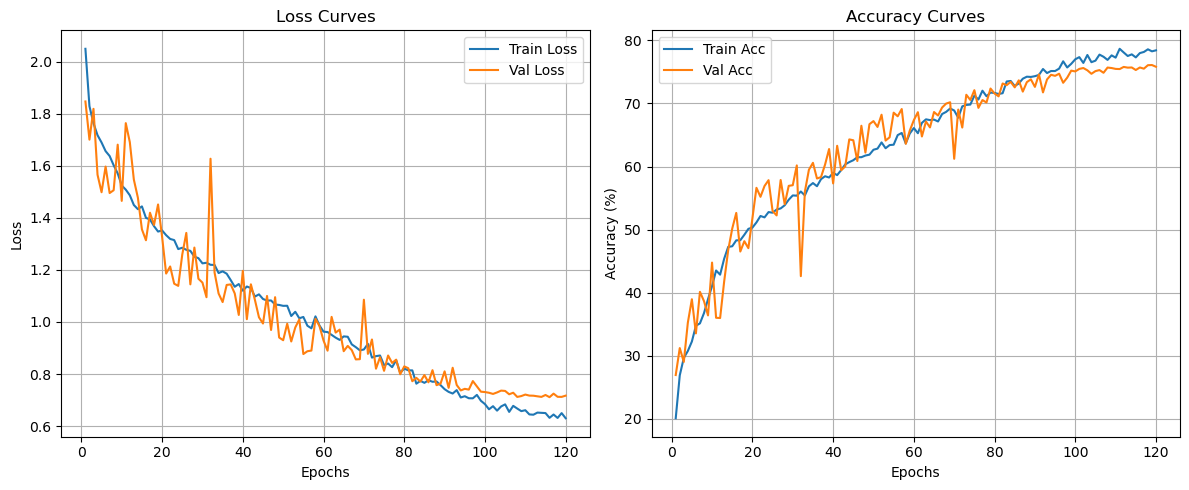

In [25]:
import copy

final_epochs = 120
patience = 15
counter = 0
best_val_loss = float('inf')

if best_params is None:
    best_params = {
        "base_width": 64,
        "optimizer": "adam",
        "batch_size": 128,
        "lr": 1e-3,
        "weight_decay": 1e-4
    }
    print(
        f"Best params not set, defaulting to width={best_params['base_width']}, "
        f"opt={best_params['optimizer']}, bs={best_params['batch_size']}, "
        f"lr={best_params['lr']}, wd={best_params['weight_decay']}"
    )
else:
    print(
        f"Final Training with Best Hyperparameters: width={best_params['base_width']}, "
        f"opt={best_params['optimizer']}, bs={best_params['batch_size']}, "
        f"lr={best_params['lr']}, wd={best_params['weight_decay']}"
    )

full_train_loader = DataLoader(
    train_ds_aug,
    batch_size=best_params["batch_size"],
    shuffle=True,
    num_workers=2
)

model = CNN(num_classes=10, base_width=best_params["base_width"]).to(device)
best_model_wts = copy.deepcopy(model.state_dict())

criterion = nn.CrossEntropyLoss()
lr = best_params["lr"]
wd = best_params["weight_decay"]
if best_params["optimizer"] == "adam":
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
else:
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=final_epochs, eta_min=1e-5)

# Use test split as validation for epoch curves
val_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False, num_workers=2)

def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(loader.dataset)
    acc = 100 * correct / total
    return avg_loss, acc

train_losses = []
train_accs = []
val_losses = []
val_accs = []

print(f"Starting training for {final_epochs} epochs with patience={patience}...")

for epoch in tqdm(range(final_epochs)):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in full_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(full_train_loader.dataset)
    train_acc = 100 * correct / total
    val_loss, val_acc = evaluate_model(model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch + 1) % 10 == 0 or (epoch + 1) == final_epochs:
        print(
            f"Epoch [{epoch+1}/{final_epochs}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%"
        )

# Load best model weights
model.load_state_dict(best_model_wts)
print(f"Loaded best model weights with Val Loss: {best_val_loss:.4f}")

actual_epochs = len(train_losses)
epochs_range = range(1, actual_epochs + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs_range, train_losses, label='Train Loss')
ax1.plot(epochs_range, val_losses, label='Val Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curves')
ax1.grid(True)
ax1.legend()

ax2.plot(epochs_range, train_accs, label='Train Acc')
ax2.plot(epochs_range, val_accs, label='Val Acc')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy Curves')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

### Might change to cosine annealing with warm restarts to explore if effect of learning rate improves in later epochs as well

## Test Evaluation

In [26]:
model.eval()
correct = 0
total = 0

print("Evaluating on Test Set...")
with torch.no_grad():
    for data in tqdm(test_loader, desc="Testing"):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Final Accuracy on the 8000 test images: {100 * correct / total:.2f} %')

Evaluating on Test Set...


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Final Accuracy on the 8000 test images: 75.70 %
